### Import Packages

In [58]:
# Ensure to install the following packages:
# pandas, geopandas, matplotlib, scikit-learn, scipy, pysal

#Importing the required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
import pysal as ps
from pysal.explore import esda
from splot.esda import plot_local_autocorrelation
from splot.esda import lisa_cluster
from esda.getisord import G_Local
from splot.esda import moran_scatterplot
from libpysal.weights import KNN
import esda
import numpy as np
import matplotlib.pyplot as plt


### Load Datasets

In [59]:
# Read the data from the CSV file
health_facilities_df = pd.read_csv('../hf_insights/Health_Facility Data - HFs_From_Ghana_HS_Website.csv')
gdf_health_facilities = gpd.GeoDataFrame(
    health_facilities_df, 
    geometry=gpd.points_from_xy(health_facilities_df.Longitude, health_facilities_df.Latitude),
    crs="EPSG:4326"
)


### Read in Admin Boundaries

In [60]:
# The path to shapefile
gdf_admin_boundaries = gpd.read_file('../hf_insights/geoBoundaries-GHA-ADM2.shp')

### Clean Data

In [61]:
print(gdf_health_facilities.isnull().sum())  # Check for missing values in health facility data
print('**************************')
print(gdf_admin_boundaries.isnull().sum())  # Check for missing values in administrative boundary data


Region             0
District           0
FacilityName       0
Type               0
Town             153
Ownership          0
Latitude          24
Longitude         24
Unnamed: 8      3731
geometry           0
dtype: int64
**************************
shapeName       0
shapeISO      260
shapeID         0
shapeGroup      0
shapeType       0
geometry        0
dtype: int64


In [62]:
# Drop the NaN values in the health facility data
gdf_health_facilities = gdf_health_facilities.dropna(subset=['Longitude', 'Latitude'])

### Check Projection

In [63]:
print(gdf_health_facilities.crs)
print(gdf_admin_boundaries.crs)


EPSG:4326
EPSG:4326


### Preliminary Visualization

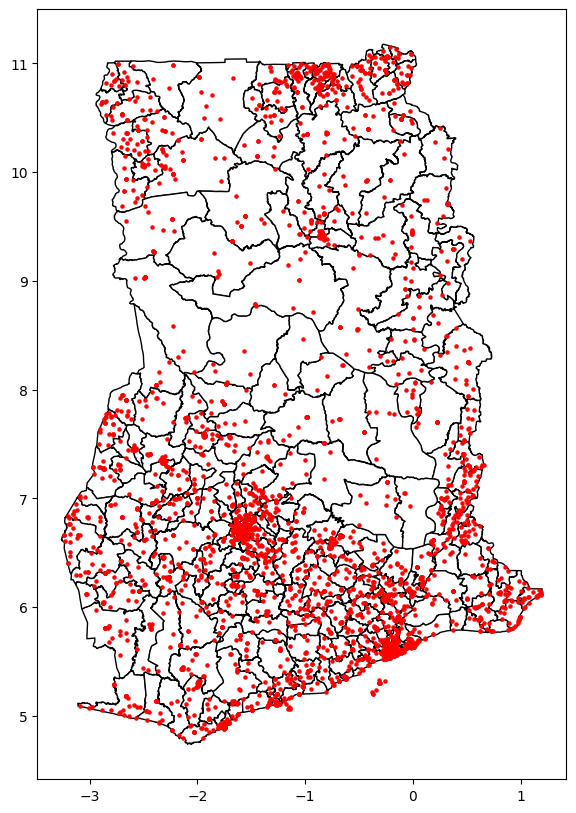

In [64]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_admin_boundaries.plot(ax=ax, color='white', edgecolor='black')
gdf_health_facilities.plot(ax=ax, markersize=5, color='red')
plt.show()


## Perform Analysis
### K-Means

In [65]:
# Extract Coordinates
coordinates = gdf_health_facilities[['Latitude', 'Longitude']].values

# Apply K-means Clustering
from sklearn.cluster import KMeans

# Number of clusters
k = 5  # Adjust based on your analysis and needs

# Run K-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(coordinates)

# Assign cluster labels to your original GeoDataFrame
gdf_health_facilities['cluster_label'] = kmeans.labels_

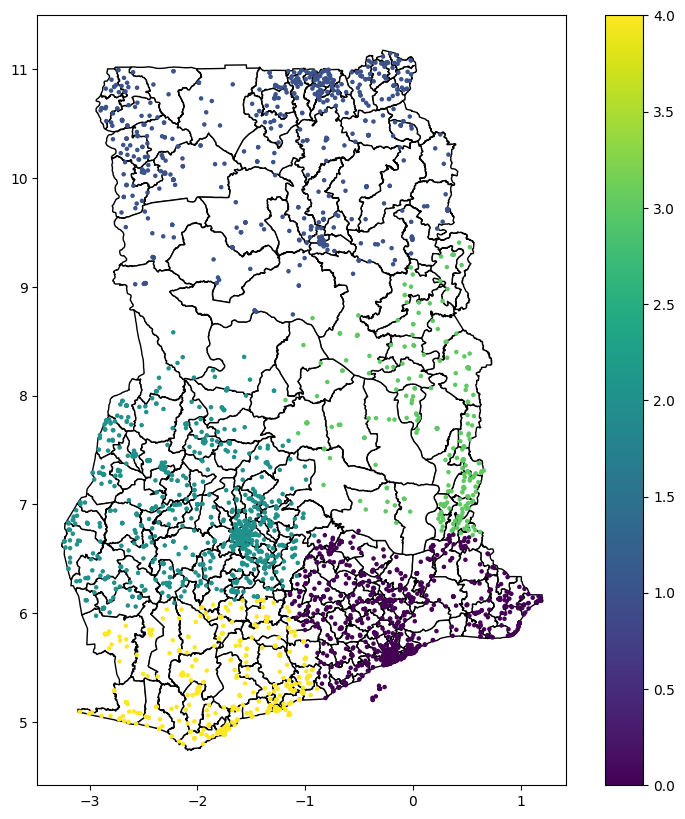

In [66]:
# Visible clusters
fig, ax = plt.subplots(figsize=(10, 10))
gdf_admin_boundaries.plot(ax=ax, color='white', edgecolor='black')
gdf_health_facilities.plot(column='cluster_label', ax=ax, markersize=5, cmap='viridis', legend=True)
plt.show()

### Create a Spatial Weights Matrix

In [67]:
from shapely.geometry import Point

# Check if 'Latitude' and 'Longitude' columns exist
if 'Latitude' in gdf_health_facilities.columns and 'Longitude' in gdf_health_facilities.columns:
    # Create Point geometries from latitude and longitude columns
    gdf_health_facilities['geometry'] = gdf_health_facilities.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
    # Convert DataFrame to GeoDataFrame, if it's not already
    gdf_health_facilities = gpd.GeoDataFrame(gdf_health_facilities, geometry='geometry')
    # Ensure the GeoDataFrame has the correct CRS (Coordinate Reference System)
    gdf_health_facilities.crs = "EPSG:4326"  # Assuming latitude/longitude, adjust if using a different CRS
else:
    print("Latitude and/or Longitude columns not found.")

# Verify that all geometries are Points
all_points = all(isinstance(geom, Point) for geom in gdf_health_facilities.geometry)
if all_points:
    print("All geometries are Points.")
else:
    print("Not all geometries are Points. Please check your data.")


All geometries are Points.


In [68]:
from libpysal.weights import KNN

# Assuming your GeoDataFrame is named gdf_health_facilities and already cleaned from the previous step
# Convert your GeoDataFrame to the correct format if not done yet
gdf_health_facilities = gdf_health_facilities.set_geometry('geometry')
gdf_health_facilities.crs = "EPSG:4326"  # Ensure CRS is correctly set

# Create a spatial weights matrix using k-nearest neighbors
knn_weights = KNN.from_dataframe(gdf_health_facilities, k=5)  # You can adjust 'k' based on your dataset
knn_weights.transform = 'r'  # Row-standardize the weights


/opt/homebrew/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


/opt/homebrew/lib/python3.11/site-packages/esda/getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  w = W(neighbors, weights, ids, **kwargs)


ValueError: aspect must be finite and positive 

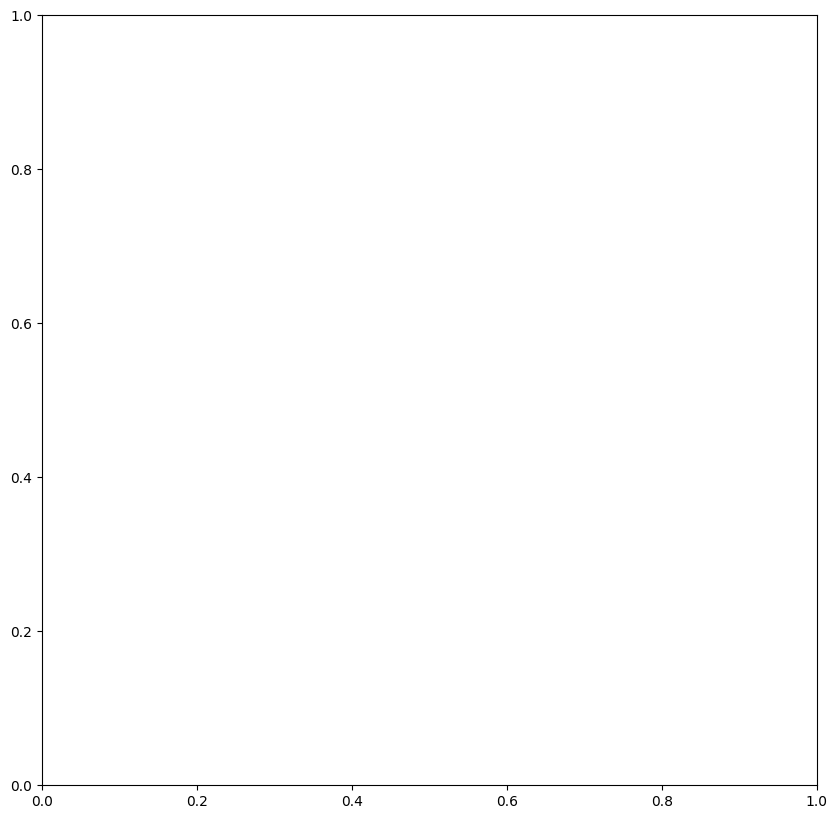

In [69]:
from esda.getisord import G_Local

# Dummy attribute - replace with a relevant attribute if available
# Here, we'll just use a ones array as a placeholder, assuming each facility is equally important
# In real analysis, this could be the number of beds, services offered, etc.
y = np.ones(len(gdf_health_facilities))

gi_star = G_Local(y, knn_weights, star=True)

# Significant hot spots and cold spots
significant = gi_star.p_sim < 0.05
hot_spots = gi_star.Zs > 0
cold_spots = gi_star.Zs < 0

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_health_facilities[significant & hot_spots].plot(ax=ax, color='red', markersize=5, label='Hot spots')
gdf_health_facilities[significant & cold_spots].plot(ax=ax, color='blue', markersize=5, label='Cold spots')
gdf_health_facilities.plot(ax=ax, color='grey', markersize=1, alpha=0.5, label='Not significant')
gdf_health_facilities.boundary.plot(ax=ax, color=None, edgecolor='k', linewidth=1, alpha=0.5)
plt.legend()
plt.show()


### Assesscibily Analysis

In [70]:
import rasterio
import numpy as np

# Load your population raster data
with rasterio.open('/Users/prince.asiamah/Library/CloudStorage/OneDrive-UniversityofCalgary/MATLAB/Spatial_Database/dev/final_project/data/gha_ppp_2020_UNadj.tif') as src:
    population = src.read(1)  # Read the first band into a 2D array
    transform = src.transform  # Get the affine transform for the raster

# Get coordinates for all populated cells (you might want to set a threshold for what you consider 'populated')
rows, cols = np.nonzero(population > 0)  # Adjust 0 if you have a different threshold for being considered 'populated'
coords = rasterio.transform.xy(transform, rows, cols)  # Convert array indices to spatial coordinates


RasterioIOError: '/Users/prince.asiamah/Library/CloudStorage/OneDrive-UniversityofCalgary/MATLAB/Spatial_Database/dev/final_project/data/gha_ppp_2020_UNadj.tif' not recognized as a supported file format.